## Convolutional NN to classify govuk content to level2 taxons

Based on:
https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

## To do:
- ~~Consider grouping very small classes (especially if too small for evaluation)~~
- ~~Split data into training, validation and test to avoid overfitting validation data during hyperparamter searches & model architecture changes~~
- ~~Try learning embeddings~~--
- Try changing pos_ratio
- Try implementing class_weights during model fit (does this do the same as the weighted binary corss entropy?)
- Work on tensorboard callbacks
- ~~Create dictionary of class indices to taxon names for viewing results~~
- Check model architecture
- consider relationship of training error to validation error - overfitting/bias?
- train longer
- Try differnet max_sequence_length
- Check batch size is appropriate
- Also think about:
  - regularization (e.g. dropout) 
  - fine-tuning the Embedding layer

### Load requirements and data

TODO: edit requirement.txt to include only these packages and do not include tensorflow because this conflicts with tf on AWS when using on GPU.

In [85]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical, layer_utils, plot_model

from keras.layers import (Embedding, Input, Dense, 
                          Activation, Conv1D, MaxPooling1D, Flatten)
from keras.models import Model, Sequential
from keras.optimizers import rmsprop
from keras.callbacks import TensorBoard, Callback
import keras.backend as K
from keras.losses import binary_crossentropy

from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score 
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.utils import class_weight

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import functools


### Environmental vars

In [86]:
DATADIR=os.getenv('DATADIR')

## Hyperparameters

Intuition for POS_RATIO is that it penalises the prediction of zero for everything, which is attractive to the model because the multilabel y matrix is super sparse. 

Increasing POS_RATIO should penalise predicting zeros more.

In [105]:
#MAX_NB_WORDS
MAX_SEQUENCE_LENGTH =1000
EMBEDDING_DIM = 100 # keras embedding layer output_dim = Dimension of the dense embedding
P_THRESHOLD = 0.5 #Threshold for probability of being assigned to class
POS_RATIO = 0.5 #ratio of positive to negative for each class in weighted binary cross entropy loss function
NUM_WORDS=20000 #keras tokenizer num_words: None or int. Maximum number of words to work with 
#(if set, tokenization will be restricted to the top num_words most common words in the dataset).

### Read in data
Content items tagged to level 2 taxons or lower in the topic taxonomy

In [91]:
labelled_level2 = pd.read_csv(os.path.join(DATADIR, 'labelled_level2.csv'), dtype=object)

### Create dictionary mapping taxon codes to string labels

In [92]:
#COLLAPSE World level2taxons
labelled_level2.loc[labelled_level2['level1taxon'] == 'World', 'level2taxon'] = 'world_level1'

#creating categorical variable for level2taxons from values
labelled_level2['level2taxon'] = labelled_level2['level2taxon'].astype('category')

#Get the category numeric values (codes) and avoid zero-indexing
labels = labelled_level2['level2taxon'].cat.codes + 1

#create dictionary of taxon category code to string label for use in model evaluation
labels_index = dict(zip((labels), labelled_level2['level2taxon']))
labels_index

{1: 'Administrative justice reform',
 2: 'Adoption, fostering and surrogacy',
 3: 'Afghanistan',
 4: 'Armed Forces Covenant',
 5: 'Armed forces',
 6: 'Armed forces and Ministry of Defence reform',
 7: 'Armed forces support for activities in the UK',
 8: 'Arts and culture',
 9: 'Assessing environmental impact',
 10: 'Asylum',
 11: 'Attorney General guidance to the legal profession',
 12: 'Aviation',
 13: 'Benefits entitlement',
 14: 'Benefits for families',
 15: 'Biodiversity and ecosystems',
 16: 'Boating and inland waterways',
 17: 'Brexit',
 18: 'Brexit and the EU',
 19: 'British citizenship ',
 20: 'British nationals overseas',
 21: 'Business and enterprise',
 22: 'Business and the environment',
 23: 'Business tax',
 24: 'Byelaws',
 25: 'Carers and disability benefits',
 26: "Carers' health",
 27: 'Certificates, register offices, changes of name or gender',
 28: 'Charities, volunteering and honours',
 29: 'Child Benefit',
 30: 'Child maintenance reform',
 31: 'Childcare and early ye

In [93]:
print(len(labels_index))

210


### Create target/Y 

Note: when using the categorical_crossentropy loss, your targets should be in categorical format (e.g. if you have 10 classes, the target for each sample should be a 10-dimensional vector that is all-zeros expect for a 1 at the index corresponding to the class of the sample).

In multilabel learning, the joint set of binary classification tasks is expressed with label binary indicator array: each sample is one row of a 2d array of shape (n_samples, n_classes) with binary values:  
the one, i.e. the non zero elements, corresponds to the subset of labels.  
An array such as np.array([[1, 0, 0], [0, 1, 1], [0, 0, 0]]) represents label 0 in the first sample, labels 1 and 2 in the second sample, and no labels in the third sample.  
Producing multilabel data as a list of sets of labels may be more intuitive.

####  First reshape wide to get columns for each level2taxon and row number = number unique urls

In [94]:
#get a smaller copy of data for pivoting ease (think you can work from full data actually and other cols get droopedauto)

level2_reduced = labelled_level2[['content_id', 'level2taxon', 'combined_text']].copy(deep=True)

#how many level2taxons are there?
print('Number of unique level2taxons: {}'.format(level2_reduced.level2taxon.nunique()))

#count the number of taxons per content item into new column
level2_reduced['num_taxon_per_content'] = level2_reduced.groupby(["content_id"])['content_id'].transform("count")

#Add 1 because of zero-indexing to get 1-number of level2taxons as numerical targets
level2_reduced['level2taxon_code'] = level2_reduced.level2taxon.astype('category').cat.codes + 1

Number of unique level2taxons: 210


In [98]:
#reshape to wide per taxon and keep the combined text so indexing is consistent when splitting X from Y

multilabel = (level2_reduced.pivot_table(index=['content_id', 'combined_text'], 
                  columns='level2taxon_code', 
                  values='num_taxon_per_content'))
print('level2reduced shape: {}'.format(level2_reduced.shape))
print('pivot table shape (no duplicates): {} '.format(multilabel.shape))

level2reduced shape: (173560, 5)
pivot table shape (no duplicates): (114048, 210) 


In [99]:
#THIS IS WHY INDEXING IS NOT ZERO-BASED
#convert the number_of_taxons_per_content values to 1, meaning there was an entry for this taxon and this content_id, 0 otherwise
binary_multilabel = multilabel.notnull().astype('int')

In [100]:
#will convert columns to an array of shape
print('Shape of Y multilabel array before train/val/test split:{}'.format(binary_multilabel[list(binary_multilabel.columns)].values.shape))

Shape of Y multilabel array before train/val/test split:(114048, 210)


In [101]:
#convert columns to an array. Each row represents a content item, each column an individual taxon
binary_multilabel = binary_multilabel[list(binary_multilabel.columns)].values
print('Example row of multilabel array {}'.format(binary_multilabel[2]))

Example row of multilabel array [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [102]:
type(binary_multilabel)

numpy.ndarray

### Create language data/X

format our text samples and labels into tensors that can be fed into a neural network. To do this, we will rely on Keras utilities keras.preprocessing.text.Tokenizer and keras.preprocessing.sequence.pad_sequences.

In [103]:
#the pivot table has two indices
multilabel.index.names

FrozenList(['content_id', 'combined_text'])

In [104]:
#extract combined text index to array
texts = multilabel.index.get_level_values('combined_text')
texts.shape

(114048,)

### Tokenizer

Tokenizer = Class for vectorizing texts, or/and turning texts into sequences (=list of word indexes, where the word of rank i in the dataset (starting at 1) has index i)

In [106]:
# Bag of words method
tokenizer = Tokenizer(num_words=NUM_WORDS) #num_words: None or int. Maximum number of words to work with 
# (if set, tokenization will be restricted to the top num_words most common words in the dataset).

# apply tokenizer to our text data
tokenizer.fit_on_texts(texts)

# list of word indexes, where the word of rank i in the dataset (starting at 1) has index i
sequences = tokenizer.texts_to_sequences(texts) #yield one sequence per input text

# dictionary mapping words (str) to their rank/index (int).
word_index = tokenizer.word_index  # Only set after fit_on_texts was called.
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen= MAX_SEQUENCE_LENGTH) #MAX_SEQUENCE_LENGTH

Found 213132 unique tokens.


In [107]:
print('Shape of label tensor:', binary_multilabel.shape)
print('Shape of data tensor:', data.shape)

Shape of label tensor: (114048, 210)
Shape of data tensor: (114048, 1000)


### Data split
- Training data = 80%
- validation data = 10%
- Test data = 10%

In [19]:
# shuffle data and standardise indices
indices = np.arange(data.shape[0])
np.random.seed(0)
np.random.shuffle(indices)

In [20]:
data = data[indices]
labels = binary_multilabel[indices]

In [21]:
nb_test_samples = int(0.1 * data.shape[0]) #validation split
print('nb_test samples:', nb_test_samples)

nb_val_samples = int(0.2 * data.shape[0]) #validation split
print('nb_val samples:', nb_val_samples)

nb_training_samples = int(0.8 * data.shape[0]) #validation split
print('nb_training samples:', nb_training_samples)

nb_test samples: 11404
nb_val samples: 22809
nb_training samples: 91238


In [22]:
x_train = data[:-nb_val_samples]
print('Shape of x_train:', x_train.shape)
y_train = labels[:-nb_val_samples]
print('Shape of y_train:', y_train.shape)

x_val = data[-nb_val_samples:-nb_test_samples]
print('Shape of x_val:', x_val.shape)
y_val = labels[-nb_val_samples:-nb_test_samples]
print('Shape of y_val:', y_val.shape)

x_test = data[-nb_test_samples:]
print('Shape of x_val:', x_val.shape)
y_test = labels[-nb_test_samples:]
print('Shape of y_val:', y_val.shape)

Shape of x_train: (91239, 1000)
Shape of y_train: (91239, 210)
Shape of x_val: (11405, 1000)
Shape of y_val: (11405, 210)
Shape of x_val: (11405, 1000)
Shape of y_val: (11405, 210)


In [23]:
#check these are differnt arrays!
np.array_equal(y_val, y_test)

False

### preparing the Embedding layer

NB stopwords haven't been removed yet...

In [25]:
embedding_layer = Embedding(len(word_index) + 1, 
                            EMBEDDING_DIM, 
                            input_length=MAX_SEQUENCE_LENGTH)

An Embedding layer should be fed sequences of integers, i.e. a 2D input of shape (samples, indices). These input sequences should be padded so that they all have the same length in a batch of input data (although an Embedding layer is capable of processing sequence of heterogenous length, if you don't pass an explicit input_length argument to the layer).

All that the Embedding layer does is to map the integer inputs to the vectors found at the corresponding index in the embedding matrix, i.e. the sequence [1, 2] would be converted to [embeddings[1], embeddings[2]]. This means that the output of the Embedding layer will be a 3D tensor of shape (samples, sequence_length, embedding_dim).

### Estimate class weights for unbalanced datasets.
paramter to model.fit = __class_weight__: Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.

Implement class_weight from sklearn:

- Import the module 

`from sklearn.utils import class_weight`
- calculate the class weight, If ‘balanced’, class weights will be given by n_samples / (n_classes * np.bincount(y)):

`class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)`

- change it to a dict in order to work with Keras.

`class_weight_dict = dict(enumerate(class_weight))`

- Add to model fitting

`model.fit(X_train, y_train, class_weight=class_weight)`

In [26]:
# class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weight_dict = dict(enumerate(class_weight))

### Custom loss function

In [27]:
class WeightedBinaryCrossEntropy(object):

    def __init__(self, pos_ratio):
        neg_ratio = 1. - pos_ratio
        #self.pos_ratio = tf.constant(pos_ratio, tf.float32)
        self.pos_ratio = pos_ratio
        #self.weights = tf.constant(neg_ratio / pos_ratio, tf.float32)
        self.weights = neg_ratio / pos_ratio
        self.__name__ = "weighted_binary_crossentropy({0})".format(pos_ratio)

    def __call__(self, y_true, y_pred):
        return self.weighted_binary_crossentropy(y_true, y_pred)

    def weighted_binary_crossentropy(self, y_true, y_pred):
            # Transform to logits
            epsilon = tf.convert_to_tensor(K.common._EPSILON, y_pred.dtype.base_dtype)
            y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
            y_pred = tf.log(y_pred / (1 - y_pred))

            cost = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, self.weights)
            return K.mean(cost * self.pos_ratio, axis=-1)
    
y_true_arr = np.array([0,1,0,1], dtype="float32")
y_pred_arr = np.array([0,0,1,1], dtype="float32")
y_true = tf.constant(y_true_arr)
y_pred = tf.constant(y_pred_arr)

with tf.Session().as_default(): 
    print(WeightedBinaryCrossEntropy(0.5)(y_true, y_pred).eval())
    print(binary_crossentropy(y_true, y_pred).eval())


4.00756
8.01512


### difficulty getting global precision/recall metrics . CAUTION interpreting monitoring metrics
fcholltet: "Basically these are all global metrics that were approximated
batch-wise, which is more misleading than helpful. This was mentioned in
the docs but it's much cleaner to remove them altogether. It was a mistake
to merge them in the first place."

In [28]:
def mcor(y_true, y_pred):
     #matthews_correlation
     y_pred_pos = K.round(K.clip(y_pred, 0, 1))
     y_pred_neg = 1 - y_pred_pos
 
 
     y_pos = K.round(K.clip(y_true, 0, 1))
     y_neg = 1 - y_pos
 
 
     tp = K.sum(y_pos * y_pred_pos)
     tn = K.sum(y_neg * y_pred_neg)
 
 
     fp = K.sum(y_neg * y_pred_pos)
     fn = K.sum(y_pos * y_pred_neg)
 
 
     numerator = (tp * tn - fp * fn)
     denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
 
 
     return numerator / (denominator + K.epsilon())

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

## Training a 1D convnet

### 1. Create model

In [29]:
NB_CLASSES = y_train.shape[1]
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32') #MAX_SEQUENCE_LENGTH
embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 5, activation='relu', name = 'conv0')(embedded_sequences)

x = MaxPooling1D(5, name = 'max_pool0')(x)

x = Conv1D(128, 5, activation='relu', name = 'conv1')(x)

x = MaxPooling1D(5 , name = 'max_pool1')(x)

x = Conv1D(128, 5, activation='relu', name = 'conv2')(x)

x = MaxPooling1D(35, name = 'global_max_pool')(x)  # global max pooling

x = Flatten()(x) #reduce dimensions from 3 to 2; convert to vector + FULLYCONNECTED

x = Dense(128, activation='relu')(x)

x = Dense(NB_CLASSES, activation='sigmoid', name = 'fully_connected')(x)

# # The Model class turns an input tensor and output tensor into a model
# This creates Keras model instance, will use this instance to train/test the model.
model = Model(sequence_input, x)

In [30]:
sequence_input

<tf.Tensor 'input_1:0' shape=(?, 1000) dtype=int32>

### 2. Compile model

In [31]:
model.compile(loss=WeightedBinaryCrossEntropy(POS_RATIO),
              optimizer='rmsprop',
              metrics=['binary_accuracy', precision, recall, f1])

Metric values are recorded at the end of each epoch on the training dataset. If a validation dataset is also provided, then the metric recorded is also calculated for the validation dataset.

All metrics are reported in verbose output and in the history object returned from calling the fit() function. In both cases, the name of the metric function is used as the key for the metric values. In the case of metrics for the validation dataset, the “val_” prefix is added to the key.

You have now built a function to describe your model. To train and test this model, there are four steps in Keras:
1. Create the model by calling the function above
2. Compile the model by calling `model.compile(optimizer = "...", loss = "...", metrics = ["accuracy"])`
3. Train the model on train data by calling `model.fit(x = ..., y = ..., epochs = ..., batch_size = ...)`
4. Test the model on test data by calling `model.evaluate(x = ..., y = ...)`

If you want to know more about `model.compile()`, `model.fit()`, `model.evaluate()` and their arguments, refer to the official [Keras documentation](https://keras.io/models/model/).


In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         21313300  
_________________________________________________________________
conv0 (Conv1D)               (None, 996, 128)          64128     
_________________________________________________________________
max_pool0 (MaxPooling1D)     (None, 199, 128)          0         
_________________________________________________________________
conv1 (Conv1D)               (None, 195, 128)          82048     
_________________________________________________________________
max_pool1 (MaxPooling1D)     (None, 39, 128)           0         
_________________________________________________________________
conv2 (Conv1D)               (None, 35, 128)           82048     
__________

### Tensorboard callbacks /metrics /monitor training

<span style="color:red"> **Size of these files is killing storage during training. Is it histograms?**</span>

In [33]:
tb = TensorBoard(log_dir='./learn_embedding_logs', histogram_freq=1, write_graph=True, write_images=False)

In [37]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
 
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.model.validation_data[0]))).round()
        val_targ = self.model.validation_data[1]
        
        self.val_f1s.append(f1_score(val_targ, val_predict, average='micro'))
        self.val_recalls.append(recall_score(val_targ, val_predict))
        self.val_precisions.append(precision_score(val_targ, val_predict))
        print("- val_f1: %f — val_precision: %f — val_recall %f" 
                %(f1_score(val_targ, val_predict, average='micro'), 
                  precision_score(val_targ, val_predict),
                   recall_score(val_targ, val_predict)))
        return
 
metrics = Metrics()

### 3. Train model

In [35]:
# metrics callback causes: CCCCCCR55555555511155
# So disable for now

model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=10, batch_size=128, 
    callbacks=[tb]
)

Train on 91239 samples, validate on 11405 samples
Epoch 1/10
91239/91239 [==============================] - 1281s 14ms/step - loss: 0.0178 - binary_accuracy: 0.9913 - precision: 0.3261 - recall: 0.0329 - f1: nan - val_loss: 0.0132 - val_binary_accuracy: 0.9935 - val_precision: 0.6918 - val_recall: 0.1269 - val_f1: 0.2133
Epoch 2/10
91239/91239 [==============================] - 1266s 14ms/step - loss: 0.0111 - binary_accuracy: 0.9941 - precision: 0.7883 - recall: 0.2202 - f1: 0.3365 - val_loss: 0.0095 - val_binary_accuracy: 0.9946 - val_precision: 0.7336 - val_recall: 0.3609 - val_f1: 0.4828
Epoch 3/10
91239/91239 [==============================] - 1215s 13ms/step - loss: 0.0081 - binary_accuracy: 0.9952 - precision: 0.8165 - recall: 0.4127 - f1: 0.5457 - val_loss: 0.0075 - val_binary_accuracy: 0.9956 - val_precision: 0.8102 - val_recall: 0.4753 - val_f1: 0.5983
Epoch 4/10
91239/91239 [==============================] - 1206s 13ms/step - loss: 0.0066 - binary_accuracy: 0.9960 - precisio

### Evaluate model

#### Training metrics

In [36]:
y_prob = model.predict(x_train)

In [37]:
y_prob.shape

(91239, 210)

In [38]:
y_pred = y_prob.copy(deep=True)
y_pred[y_pred>P_THRESHOLD] = 1
y_pred[y_pred<P_THRESHOLD] = 0

In [39]:
f1_score(y_train, y_pred, average='micro')

0.84664166435766053

In [40]:
#average= None, the scores for each class are returned.
precision_recall_fscore_support(y_train, y_pred, average=None, sample_weight=None)

/Users/ellieking/Documents/tag_tax/govuk-taxonomy-supervised-learning/tax_SL/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ellieking/Documents/tag_tax/govuk-taxonomy-supervised-learning/tax_SL/lib/python3.4/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(array([ 0.        ,  0.        ,  0.99603568,  0.9245283 ,  0.        ,
         0.71130435,  0.92307692,  0.95415848,  0.        ,  0.        ,
         0.        ,  0.88888889,  0.        ,  0.        ,  0.77304965,
         0.        ,  0.61437908,  0.        ,  0.        ,  0.8785822 ,
         0.89082579,  0.86840347,  0.92624357,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.95      ,  0.92982456,
         0.96428571,  0.        ,  0.        ,  0.87581699,  0.87960583,
         0.83870968,  0.85718976,  0.82051282,  0.95604396,  0.91125541,
         0.        ,  0.92638037,  0.        ,  0.        ,  0.8       ,
         0.        ,  0.        ,  0.94409938,  0.90016234,  0.        ,
         0.        ,  0.66666667,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.96588235,  1.        ,  0.86033058,
         0.        ,  0.        ,  0.85      ,  0.81818182,  0.        ,
         0.87676056,  0.        ,  0.        ,  0.7

In [41]:
a = precision_recall_fscore_support(y_train, y_pred, average=None, sample_weight=None)

/Users/ellieking/Documents/tag_tax/govuk-taxonomy-supervised-learning/tax_SL/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ellieking/Documents/tag_tax/govuk-taxonomy-supervised-learning/tax_SL/lib/python3.4/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [42]:
pd.DataFrame(list(a))

,0,1,2,3,4,5,6,7,8,9,...,200,201,202,203,204,205,206,207,208,209
0,0.0,0.0,0.996036,0.924528,0.0,0.711304,0.923077,0.954158,0.0,0.0,...,0.853846,0.983333,0.0,0.952007,0.0,0.0,0.0,0.0,0.0,0.985866
1,0.0,0.0,0.914468,0.360294,0.0,0.803536,0.130435,0.825964,0.0,0.0,...,0.632479,0.508621,0.0,0.682728,0.0,0.0,0.0,0.0,0.0,0.900484
2,0.0,0.0,0.953510,0.518519,0.0,0.754613,0.228571,0.885445,0.0,0.0,...,0.726678,0.670455,0.0,0.795190,0.0,0.0,0.0,0.0,0.0,0.941243
3,7.0,55.0,1099.000000,136.000000,11.0,509.000000,92.000000,1764.000000,6.0,25.0,...,351.000000,116.000000,6.0,1598.000000,7.0,150.0,21.0,30.0,36.0,1859.000000


In [43]:
f1_byclass = pd.DataFrame((a)[2], columns=['f1'])


In [44]:
support_byclass = pd.DataFrame((a)[3], columns=['support'])

f1_byclass = pd.merge(
    left=f1_byclass, 
    right=support_byclass, 
    left_index=True,
    right_index=True,
    how='outer', 
    validate='one_to_one'
)

f1_byclass['index_col'] = f1_byclass.index

In [45]:
f1_byclass['level2taxon'] = f1_byclass['index_col'].map(labels_index).copy()

In [47]:
print("At p_threshold of {}, there were {} out of {} ({})% taxons with auto-tagged content in the training data"
      .format(P_THRESHOLD, 
              f1_byclass.loc[f1_byclass['f1'] > 0].shape[0], 
              y_pred.shape[1], 
              (f1_byclass.loc[f1_byclass['f1'] > 0].shape[0]/y_pred.shape[1])*100 ))

At p_threshold of 0.5, there were 111 out of 210 (52.85714285714286)% taxons with auto-tagged content in the training data


In [48]:
no_auto_content = f1_byclass.loc[f1_byclass['f1'] == 0]
no_auto_content = no_auto_content.set_index('level2taxon')

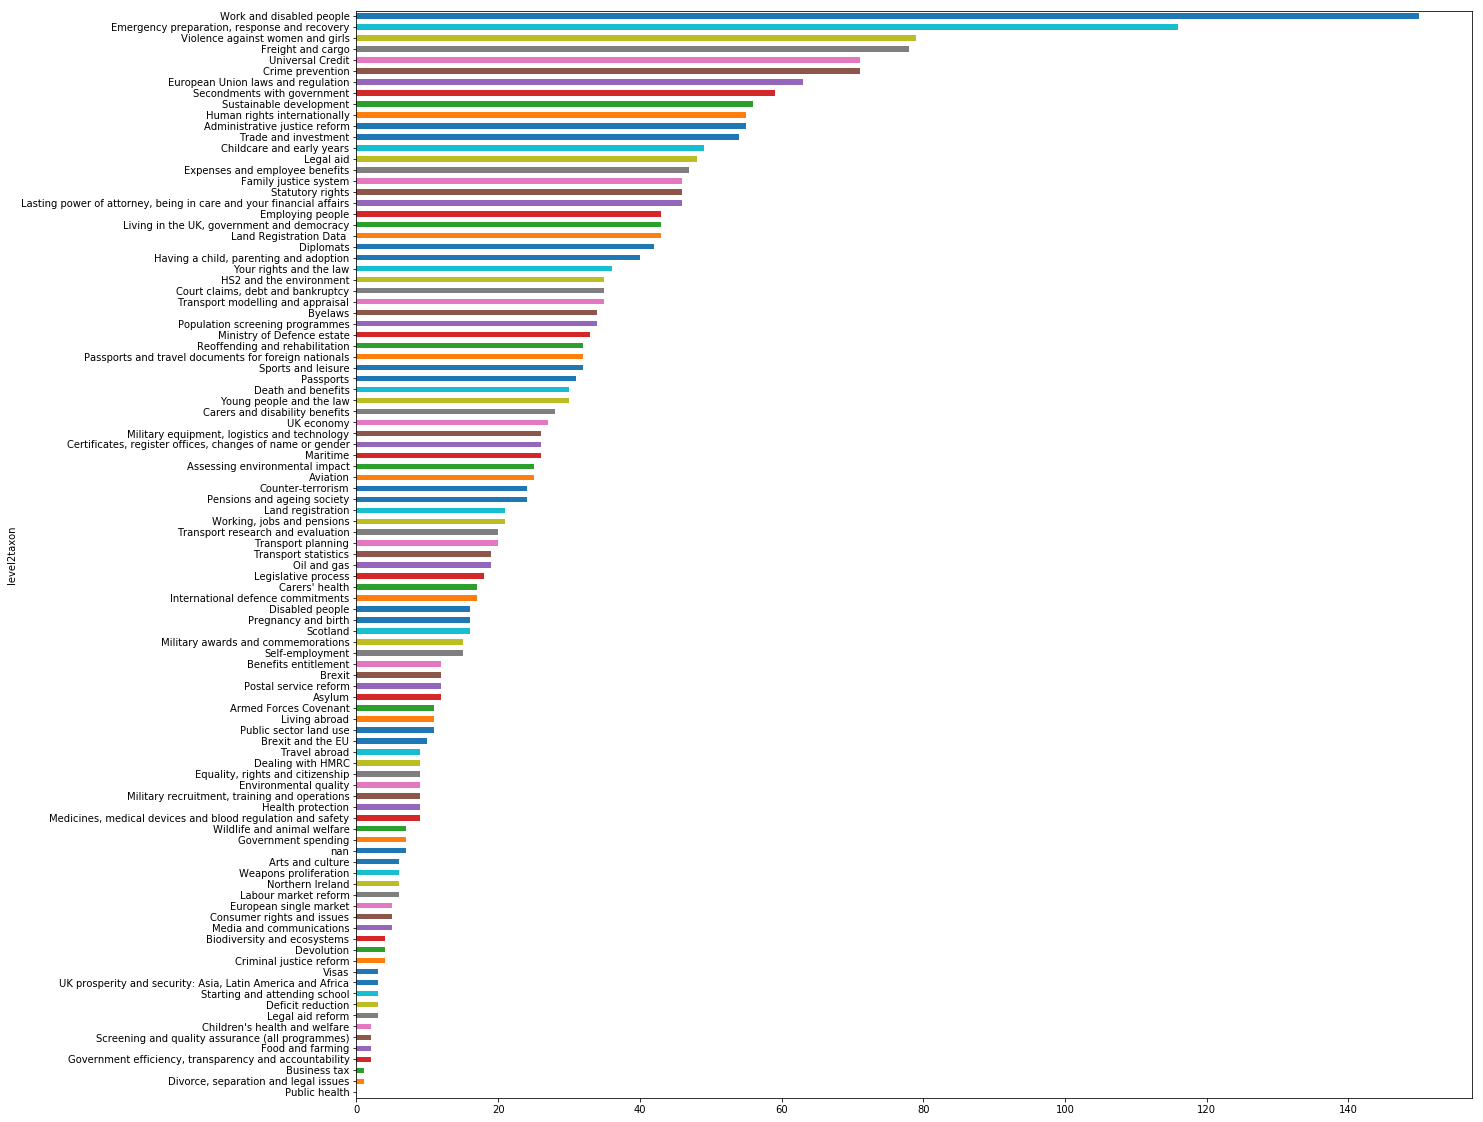

In [49]:
no_auto_content['support'].sort_values().plot( kind = 'barh', figsize=(20, 20))

In [50]:
classes_predictedto = f1_byclass.loc[f1_byclass['f1'] > 0]
classes_predictedto = classes_predictedto.set_index('level2taxon') 

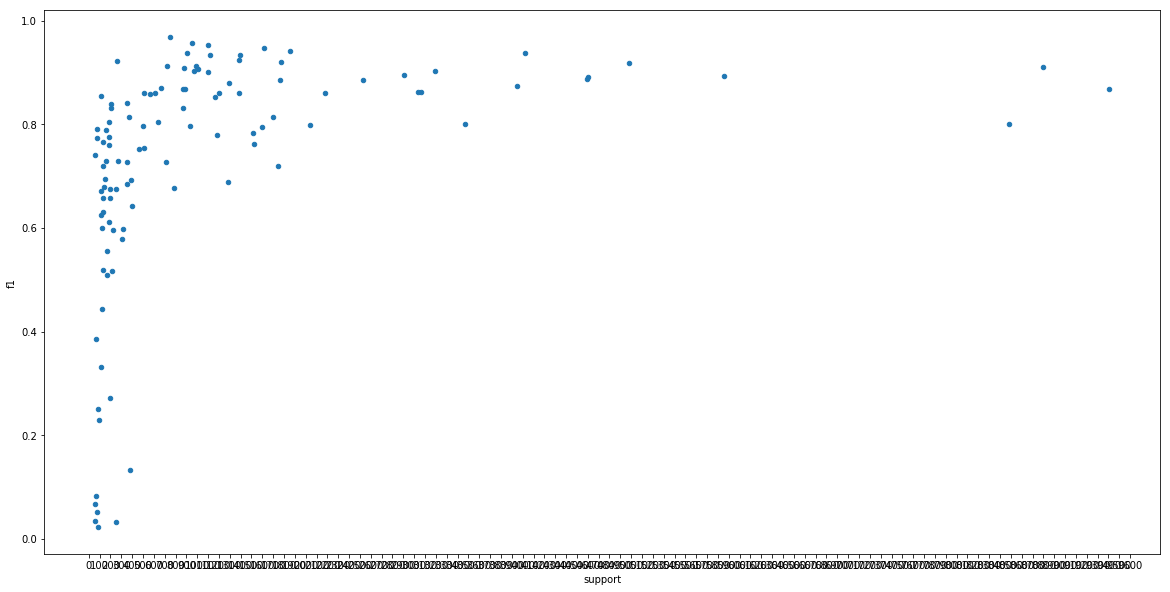

In [51]:
classes_predictedto.plot.scatter(x='support', y='f1', figsize=(20, 10), xticks=np.arange(0, 9700, 100))

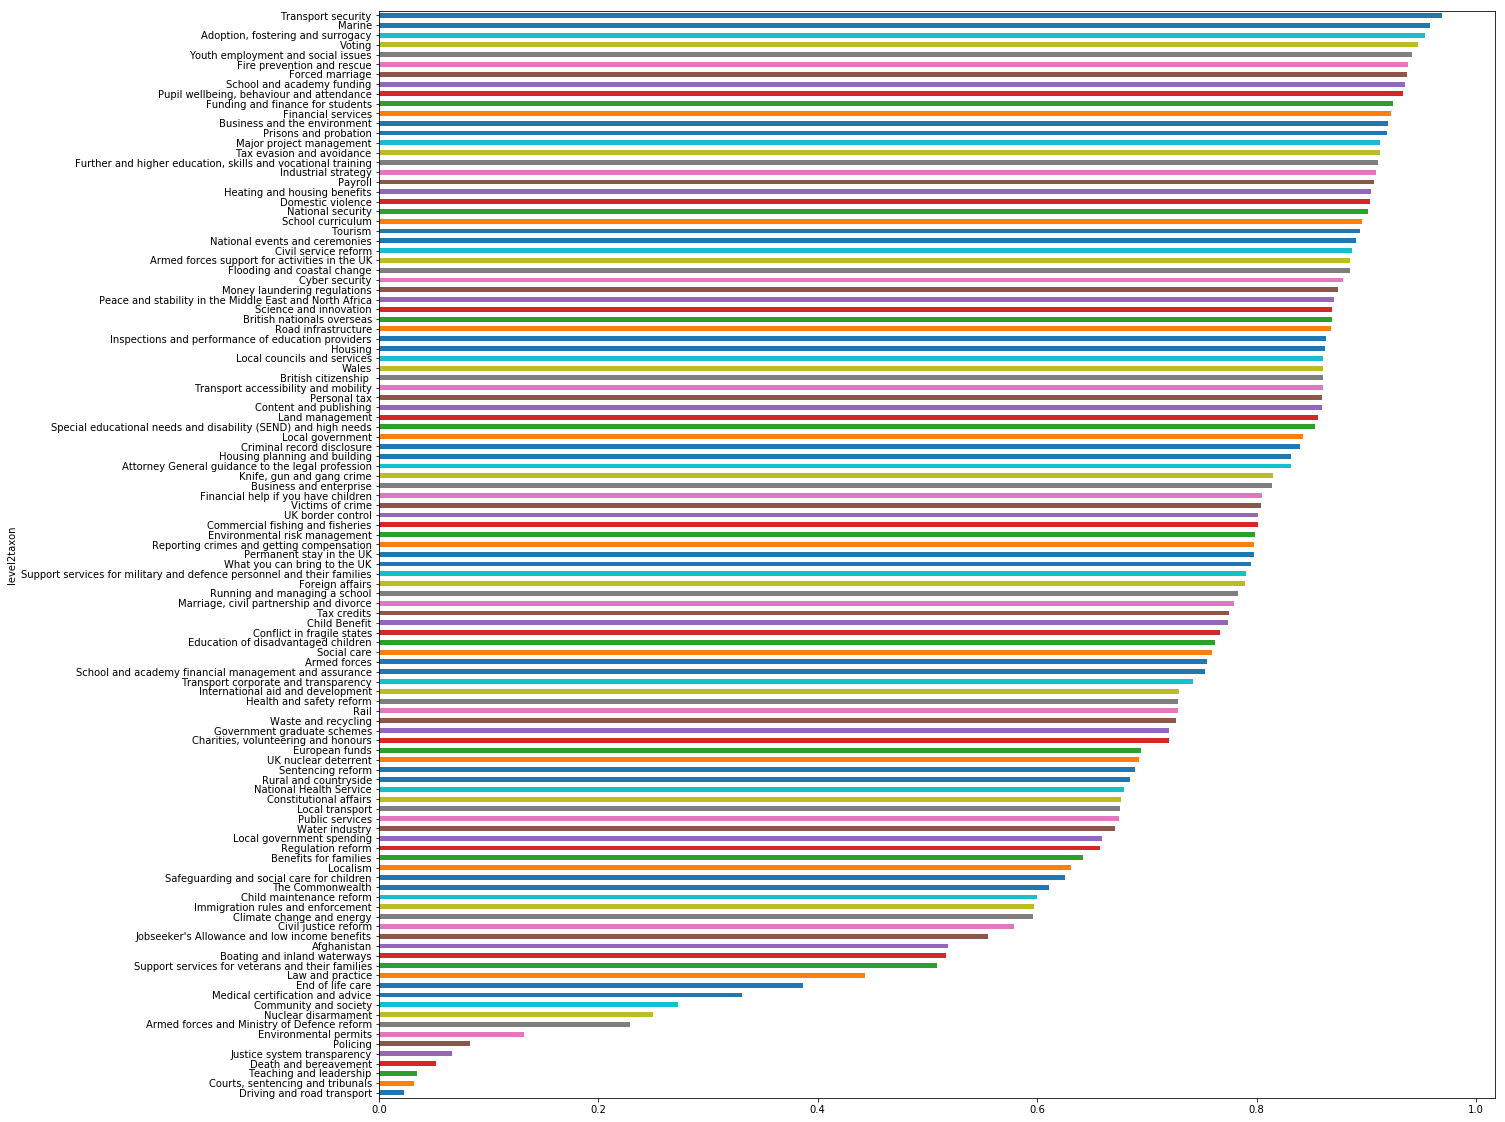

In [52]:
classes_predictedto['f1'].sort_values().plot( kind = 'barh', figsize=(20, 20))

In [53]:
#Calculate globally by counting the total true positives, false negatives and false positives.
precision_recall_fscore_support(y_train, y_pred, average='micro', sample_weight=None) 

(0.89148318909900803, 0.80609515033515156, 0.84664166435766053, None)

In [54]:
#Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account
precision_recall_fscore_support(y_train, y_pred, average='macro', sample_weight=None)

/Users/ellieking/Documents/tag_tax/govuk-taxonomy-supervised-learning/tax_SL/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ellieking/Documents/tag_tax/govuk-taxonomy-supervised-learning/tax_SL/lib/python3.4/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(0.47208301099165784, 0.34918392421590738, 0.38259429164920328, None)

#### Validation metrics

In [55]:
y_pred_val = model.predict(x_val)

In [56]:
y_pred_val[y_pred_val>=P_THRESHOLD] = 1
y_pred_val[y_pred_val<P_THRESHOLD] = 0

In [57]:
#average= None, the scores for each class are returned.
precision_recall_fscore_support(y_val, y_pred_val, average=None, sample_weight=None)

/Users/ellieking/Documents/tag_tax/govuk-taxonomy-supervised-learning/tax_SL/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ellieking/Documents/tag_tax/govuk-taxonomy-supervised-learning/tax_SL/lib/python3.4/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(array([ 0.        ,  0.        ,  0.94957983,  0.66666667,  0.        ,
         0.5       ,  0.        ,  0.77018634,  0.        ,  0.        ,
         0.        ,  0.66666667,  0.        ,  0.        ,  0.37142857,
         0.        ,  0.76923077,  0.        ,  0.        ,  0.78651685,
         0.75359712,  0.66009852,  0.80090498,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  1.        ,
         0.75      ,  0.        ,  0.        ,  0.55555556,  0.75601375,
         0.57142857,  0.61989796,  0.        ,  0.71428571,  0.63157895,
         0.        ,  0.66037736,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.73913043,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.77108434,  0.        ,  0.64583333,
         0.        ,  0.        ,  1.        ,  0.25      ,  0.        ,
         0.64220183,  0.        ,  0.        ,  0.2

In [58]:
#Calculate globally by counting the total true positives, false negatives and false positives.
precision_recall_fscore_support(y_val, y_pred_val, average='micro', sample_weight=None) 

(0.75679172056921085, 0.66768787168859256, 0.70945299036190712, None)

In [59]:
#Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account
precision_recall_fscore_support(y_val, y_pred_val, average='macro', sample_weight=None)

/Users/ellieking/Documents/tag_tax/govuk-taxonomy-supervised-learning/tax_SL/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ellieking/Documents/tag_tax/govuk-taxonomy-supervised-learning/tax_SL/lib/python3.4/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(0.34972084418991684, 0.25695467956554274, 0.28580305160989877, None)

## Tag unlabelled content

In [142]:
def get_predictions(new_texts, df, level1taxon=False):
    #process data for model input
    
    new_sequences = tokenizer.texts_to_sequences(new_texts) #yield one sequence per input text

    new_word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(new_word_index))

    x_new = pad_sequences(new_sequences, maxlen= MAX_SEQUENCE_LENGTH) #MAX_SEQUENCE_LENGTH
    
    print('Shape of untagged tensor:', x_new.shape)
    
    #predict tag for untagged data
    y_pred_new = model.predict(x_new)
    
    #get model output into pandas & get a column to track index for later merge
    y_pred_new = pd.DataFrame(y_pred_new)
    y_pred_new['index_col'] = y_pred_new.index
    
    #Make long by taxon so easier to filter rows and examine effect of p_threshold
    y_pred_new = pd.melt(y_pred_new, id_vars=['index_col'],
                             var_name='level2taxon_code', value_name='probability')
    
    #get taxon names
    y_pred_new['level2taxon'] = y_pred_new['level2taxon_code'].map(labels_index)
    
    if level1taxon==False:
        #get the info about the content
        new_info = df[[ 'base_path', 'content_id', 'title', 'description', 
                   'document_type', 'publishing_app', 'locale']]
    else:
        new_info = df[[ 'base_path', 'content_id', 'title', 'description', 
                   'document_type', 'publishing_app', 'locale', 'level1taxon']]
    
    
    #merge content info with taxon prediction
    pred_new = pd.merge(
    left=new_info, 
    right=y_pred_new, 
    left_index=True,
    right_on='index_col',
    how='outer'
    )
    
    #drop the cols needed for mergingin and naming
    pred_new.drop(['index_col'], axis=1, inplace = True)
    
    #keep only rows where prob of taxon > 0.5
    
    
    return pred_new.loc[pred_new['probability'] > P_THRESHOLD] #only return rows/samples where probability is hihger than threshold
    

### Untagged

In [122]:
#read in untagged content
untagged_raw = pd.read_csv(os.path.join(DATADIR, 'untagged_content.csv'), dtype=object)

In [138]:
new_texts = untagged_raw['combined_text']

In [143]:
pred_untagged = get_predictions(new_texts, untagged_raw)

Found 279622 unique tokens.
Shape of untagged tensor: (57337, 1000)


In [177]:
#data is long by taxon
print('Number of unique content items: {}'.format(pred_untagged.content_id.nunique()))
print('Number of content items tagged to taxons with more than p_threshold: {}'.format(pred_untagged.shape))

Number of unique content item: 21910
Number of content items tagged to taxons with more than p_threshold: (28076, 10)


In [154]:
pred_untagged.loc[(pred_untagged['probability'] > 0.65) & (pred_untagged['probability'] < 0.85)].sort_values(by='probability', ascending=False)

,base_path,content_id,title,description,document_type,publishing_app,locale,level2taxon_code,probability,level2taxon
7344611,/government/news/minister-welcomes-partnership...,5d5cff76-7631-11e4-a3cb-005056011aef,minister welcomes partnership approach by police,nick herbert visited warwickshire police and w...,news_story,whitehall,en,128,0.849921,Money laundering regulations
10933697,/government/news/international-friendship-day-...,5e96a913-7631-11e4-a3cb-005056011aef,international friendship day - photography com...,photo competition to search for the best image...,world_news_story,whitehall,en,190,0.849913,UK border control
1177997,/government/publications/rolling-out-the-nhs-1...,5dc24df7-7631-11e4-a3cb-005056011aef,rolling out the nhs 111 service,letter to strategic health authorities to requ...,correspondence,whitehall,en,20,0.849869,British nationals overseas
9243450,/government/news/december-labour-market-statis...,5d2f5c39-7631-11e4-a3cb-005056011aef,december labour market statistics for scotland,unemployment in scotland fell by 5 000 to 234 ...,news_story,whitehall,en,161,0.849829,School curriculum
6774212,/government/news/2013-clinical-excellence-awar...,5e5b6913-7631-11e4-a3cb-005056011aef,2013 clinical excellence awards round opens,the latest round of national clinical excellen...,news_story,whitehall,en,118,0.849729,Marine
8605283,/government/news/david-cameron-thanks-armed-fo...,5e0c73f8-7631-11e4-a3cb-005056011aef,david cameron thanks armed forces police and o...,"""these games have yet again shown that britain...",news_story,whitehall,en,150,0.849669,"Pupil wellbeing, behaviour and attendance"
4422582,/government/news/free-support-launched-to-boos...,5c9e33d3-7631-11e4-a3cb-005056011aef,free support launched to boost small and mediu...,get it right - first time’ is aimed at busines...,news_story,whitehall,en,77,0.849636,Forced marriage
2106808,/government/publications/industrial-relations-...,5e15862b-7631-11e4-a3cb-005056011aef,industrial relations duties and trade union ac...,find out the terms of uk export finance's agre...,independent_report,whitehall,en,36,0.849629,Commercial fishing and fisheries
8391967,/drug-device-alerts/drug-alert-novomix-30-penf...,a9254e62-d4e2-4356-8bcd-c46724d57388,novomix 30 penfill 100u/ml 3ml and novomix 30 ...,(novo nordisk a/s) patients who may have recei...,medical_safety_alert,specialist-publisher,en,146,0.849611,Prisons and probation
11395820,/drug-safety-update/intrauterine-contraception...,91d9cdd3-ae9f-425a-8d7f-468f7fe17ac4,intrauterine contraception: uterine perforatio...,the most important risk factors for uterine pe...,drug_safety_update,specialist-publisher,en,198,0.849549,Voting


In [146]:
#write to csv
pred_untagged.to_csv(os.path.join(DATADIR, 'predictions_for_untagged_data_trainingdatatok.csv'), index=False)

In [144]:
# apply tokenizer to our text data
tokenizer.fit_on_texts(new_texts)

pred_untagged_refit_tok = get_predictions(new_texts, untagged_raw)


Found 279622 unique tokens.
Shape of untagged tensor: (57337, 1000)


In [145]:
#write to csv
pred_untagged_refit_tok.to_csv(os.path.join(DATADIR, 'predictions_for_untagged_data_refittok.csv'), index=False)

### New data (untagged + old taxons)

old_taxons data has no combined text. This needs fixing in the data pipeline before being able to use these data for predictions

In [109]:
#read in untagged content
new_raw = pd.read_csv(os.path.join(DATADIR, 'new_content.csv'), dtype=object)

In [112]:
new_raw.shape

(111493, 19)

In [116]:
type(new_raw['combined_text'][0])

str

In [128]:
len(new_raw[new_raw['combined_text'].isna()])

54369

In [132]:
(new_raw.loc[(new_raw['combined_text'].isna()) & (new_raw['untagged_type'] != 'untagged')]).shape

(54369, 19)

In [110]:
#make a copy so you can edit data without needed to read in each time
new_df = new_raw.copy(deep=True)

In [111]:
pred_new = get_predictions(new_df )

AttributeError: 'float' object has no attribute 'lower'

In [ ]:
#keep only rows where prob of taxon > 0.5
pred_new = pred_new.loc[pred_new['probability'] > 0.5]

In [ ]:
#write to csv
pred_new.to_csv(os.path.join(DATADIR, 'predictions_for_new_data.csv'), index=False)

### Labelled at level1only

In [155]:
labelled_level1 = pd.read_csv(os.path.join(DATADIR, 'labelled_level1.csv'), dtype=object)

In [159]:
level1_texts = labelled_level1['combined_text']

In [160]:
#reset tokenizer to training data texts
tokenizer.fit_on_texts(texts)

In [166]:
pred_labelled_level1 = get_predictions(level1_texts, labelled_level1, level1taxon=True)

Found 279622 unique tokens.
Shape of untagged tensor: (32358, 1000)


In [167]:
pred_labelled_level1.sort_values(by='probability', ascending=False)

,base_path,content_id,title,description,document_type,publishing_app,locale,level1taxon,level2taxon_code,probability,level2taxon
671411,/government/publications/memorandum-of-underst...,d9d78240-2fb8-40b1-a695-5a24b537f41b,memorandum of understanding on northern irelan...,this mou sets out arrangements between hmrc an...,policy_paper,whitehall,en,Money,20,0.999858,British nationals overseas
647201,/government/news/mou-with-qualifications-wales,5fa4fddc-c07e-4d15-95e3-516d9409aa96,mou with qualifications wales,ofqual and qualifications wales have signed a ...,news_story,whitehall,en,Corporate information,20,0.999764,British nationals overseas
5498175,/guidance/river-thames-bridges-locks-and-facil...,5f47b47a-7631-11e4-a3cb-005056011aef,river thames: bridges locks and facilities for...,details of bridge heights and dimensions locks...,detailed_guide,whitehall,en,Environment,169,0.999652,Special educational needs and disability (SEND...
647254,/government/publications/memorandum-of-underst...,8ff4b1cf-4395-48b7-bd7d-34cd58481bf3,memorandum of understanding: charity commissio...,an agreement of the relationship between the c...,policy_paper,whitehall,en,Corporate information,20,0.999640,British nationals overseas
669825,/government/publications/transit-security-acco...,09d1cd24-12de-42e6-812d-1a73de4c96ac,transit security accompanying document: guidel...,guidelines for the layout of the transit/secur...,guidance,whitehall,en,Money,20,0.999512,British nationals overseas
2449537,/government/publications/submission-document,71c837cf-d398-42da-9da3-4d8c125a4579,european union savings directive: submission d...,download and print the submission document to ...,guidance,whitehall,en,Money,75,0.999508,Flooding and coastal change
3098771,/government/publications/notice-112a-attendanc...,5fea761c-7631-11e4-a3cb-005056011aef,notice 112a: attendance at private premises by...,this notice explains how you can get hm revenu...,notice,whitehall,en,Money,95,0.999426,Inspections and performance of education provi...
4750438,/government/publications/barbados-tax-treaties,d0fb43a7-592d-423c-865d-254fb1438edf,barbados: tax treaties,tax treaties and related documents between the...,international_treaty,whitehall,en,Money,146,0.999376,Prisons and probation
4726438,/government/collections/dstls-areas-of-work-pr...,5f67eb38-7631-11e4-a3cb-005056011aef,dstl's work: programmes and facilities,this collection of documents details dstl's wo...,document_collection,whitehall,en,Defence,146,0.999243,Prisons and probation
4737428,/government/publications/controlled-drugs-annu...,10a84d9c-6f39-4a4a-811c-88ec0d6bacd8,controlled drugs: annual statistical returns g...,guidance for licence holders on the annual sta...,guidance,whitehall,en,"Crime, justice and law",146,0.999041,Prisons and probation


In [168]:
#write to csv
pred_labelled_level1.to_csv(os.path.join(DATADIR, 'predictions_for_level1only.csv'), index=False)

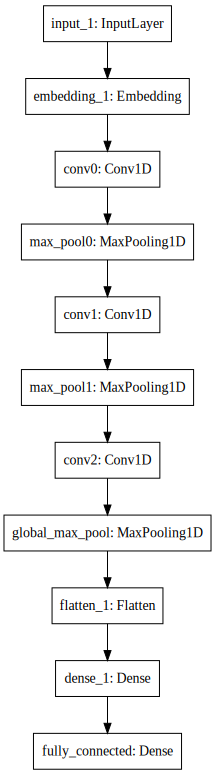

In [47]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [45]:
from keras.utils import plot_model
plot_model(model, to_file='cnn.png', show_shapes=True)